# Librairy import and configs

In [1]:
# import packages
import pandas as pd
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 10)
from ftp_functions import * #listFtp(), downloadFile(), uploadFile(), password required.

In [15]:
listFtp()

FTP password? ········


drwx---r-x   2 u45610654 ftpusers     4096 Apr  1 13:36 .
drwx---r-x   3 u45610654 ftpusers       17 Mar 31 13:56 ..
-rw----r--   1 u45610654 ftpusers     1853 Mar 31 19:07 capacity_fr.csv
-rw----r--   1 u45610654 ftpusers     1450 Apr  1 13:36 capacity_fr.pkl
-rw----r--   1 u45610654 ftpusers  1343488 Mar 31 13:56 conventional_power_plants.sqlite
-rw----r--   1 u45610654 ftpusers 23566355 Mar 31 14:04 df_data_nationales.pkl
-rw----r--   1 u45610654 ftpusers 183415129 Mar 31 16:15 df_data_regionales.pkl
-rw----r--   1 u45610654 ftpusers  4590079 Mar 31 16:07 df_temperatures.pkl
-rw----r--   1 u45610654 ftpusers  8245248 Mar 31 16:10 national_generation_capacity.sqlite
-rw----r--   1 u45610654 ftpusers  2472068 Apr  1 13:36 production_fr.pkl
-rw----r--   1 u45610654 ftpusers 378818560 Mar 31 16:06 time_series.sqlite
-rw----r--   1 u45610654 ftpusers 213696512 Mar 31 15:18 when2heat.sqlite
-rw----r--   1 u45610654 ftpusers     1173 Mar 31 13:56 wrapper.py


In [5]:
downloadFile('time_series.sqlite')
#Takes a few minutes, but should work (379MB).
downloadFile('national_generation_capacity.sqlite')
#8.3MB

In [5]:
downloadFile('df_data_nationales.pkl')

FTP password?········


In [3]:
PATH = '../data/'

In [4]:
import sqlite3
conn = {'ts': sqlite3.connect(PATH+'time_series.sqlite'),
        'cap': sqlite3.connect(PATH+'national_generation_capacity.sqlite')}

# Modélisation pour la transition énergétique

## Production vs consommation : les renouvelables

### Raw data ENTSOE
ENTSOE : *European Network of Transmission System Operators for Electricity*

ou en français : Réseau européen des gestionnaires de réseau de transport d’électricité


#### European Time series

In [5]:
query = """SELECT name FROM sqlite_master
           WHERE type='table'
           ORDER BY name;"""
pd.read_sql_query(query, conn['ts'])

,name
0,time_series_15min_singleindex
1,time_series_30min_singleindex
2,time_series_60min_singleindex


In [6]:
query = """PRAGMA table_info(time_series_60min_singleindex)"""
pd.read_sql_query(query, conn['ts']).name[2:]

2           AL_load_actual_entsoe_power_statistics
3           AT_load_actual_entsoe_power_statistics
4               AT_load_actual_entsoe_transparency
5             AT_load_forecast_entsoe_transparency
6                               AT_price_day_ahead
                          ...                     
388        UA_east_load_actual_entsoe_transparency
389      UA_east_load_forecast_entsoe_transparency
390    UA_west_load_actual_entsoe_power_statistics
391        UA_west_load_actual_entsoe_transparency
392      UA_west_load_forecast_entsoe_transparency
Name: name, Length: 391, dtype: object

In [7]:
query = """SELECT * FROM time_series_60min_singleindex"""
df_ts = pd.read_sql_query(query, conn['ts']).dropna(how="all").dropna(how="all", axis=1)
df_ts.sample(1)

,utc_timestamp,cet_cest_timestamp,AL_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BA_load_actual_entsoe_power_statistics,...,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,TR_load_actual_entsoe_power_statistics,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency,UA_east_load_actual_entsoe_transparency,UA_east_load_forecast_entsoe_transparency,UA_west_load_actual_entsoe_power_statistics,UA_west_load_actual_entsoe_transparency,UA_west_load_forecast_entsoe_transparency
12916,2006-06-23T03:00:00Z,2006-06-23T05:00:00+0200,NaN,5354.0,NaN,NaN,NaN,NaN,NaN,951.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,NaN,NaN


In [11]:
df_ts_fr = (df_ts.set_index('utc_timestamp')
            [[x for x in df_ts.columns if 'FR' in x and 'generation' in x]]
                 .dropna(how='all')
                 .dropna(how='all', axis=1))
df_ts_fr.index = pd.to_datetime(df_ts_fr.index)

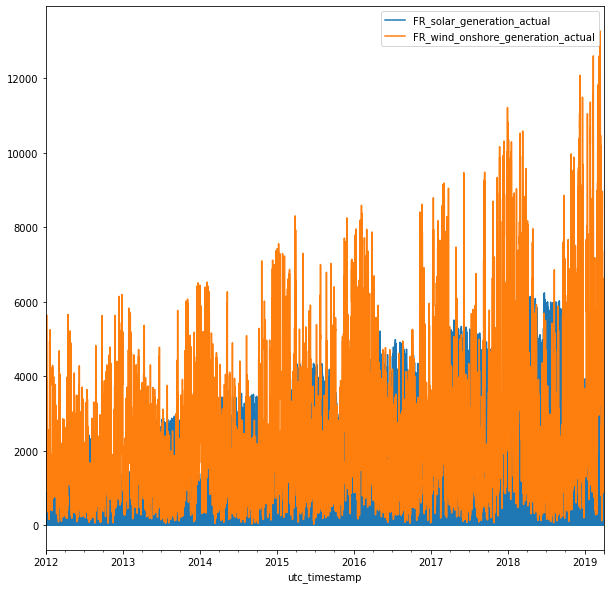

In [12]:
df_ts_fr.plot();

In [13]:
df_prod_fr =  pd.read_pickle(PATH+'production_fr.pkl')
df_prod_fr.head()

,Biomasse,Gaz,Charbon,Fioul,Hydraulique STEP,Hydraulique fil de l'eau / éclusée,Hydraulique lacs,Nucléaire,Solaire,Déchets,Éolien terrestre
2016-01-01 00:00:00,253,2265,-3,261,642,2778,511,54099,0,90,2189
2016-01-01 01:00:00,253,2232,-3,260,439,2562,555,54079,0,92,1753
2016-01-01 02:00:00,253,2259,-3,260,-864,2514,378,54058,0,93,1430
2016-01-01 03:00:00,253,2242,-3,260,-2841,2602,200,52326,0,93,1214
2016-01-01 04:00:00,252,2251,-3,258,-2876,2676,390,51806,0,90,1031


In [6]:
df_data_nationales = pd.read_pickle(PATH+'df_data_nationales.pkl')

In [17]:
df_data_nationales

,Consommation,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,Pompage,Bioénergies,Ech. physiques
DateTime,,,,,,,,,,,
2012-01-01 00:00:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0,-9806.0
2012-01-01 00:30:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0,-9806.0
2012-01-01 01:00:00,56231.0,492.0,25.0,3834.0,51747.0,3536.0,0.0,7598.0,-1730.0,721.0,-9993.0
2012-01-01 01:30:00,56075.0,491.0,25.0,3832.0,51950.0,3526.0,0.0,7299.0,-2134.0,722.0,-9636.0
2012-01-01 02:00:00,55532.0,492.0,25.0,3839.0,51625.0,3535.0,0.0,7159.0,-2449.0,719.0,-9412.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 21:30:00,60580.0,170.0,12.0,3825.0,55679.0,1406.0,-2.0,4648.0,-2572.0,1165.0,-3752.0
2018-12-31 22:00:00,59901.0,146.0,11.0,3568.0,55404.0,1452.0,-2.0,4632.0,-2657.0,1167.0,-3820.0
2018-12-31 22:30:00,60939.0,146.0,11.0,3886.0,55186.0,1569.0,-2.0,4451.0,-2815.0,1165.0,-2660.0


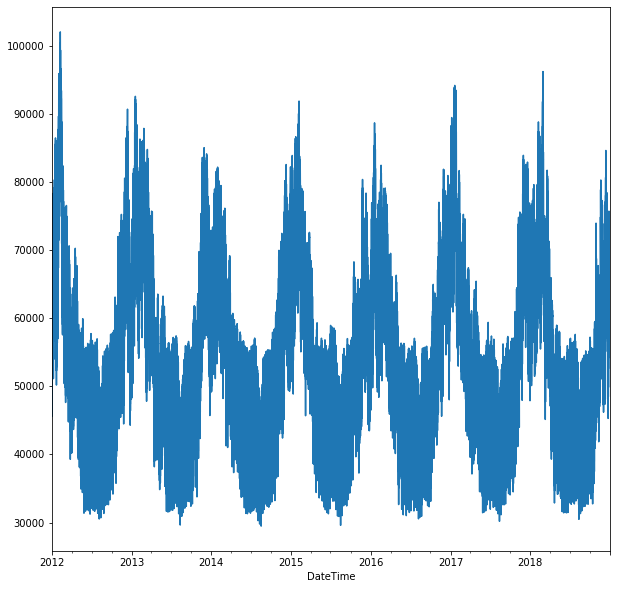

In [11]:
df_data_nationales.dropna(inplace=True)
df_data_nationales.Consommation.plot()

In [16]:
df_data_nationales.columns

Index(['Consommation', 'Fioul', 'Charbon', 'Gaz', 'Nucléaire', 'Eolien',
       'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies', 'Ech. physiques'],
      dtype='object')

In [18]:
df_data_nationales["Hydraulique"].max()

17434.0

## Temperature

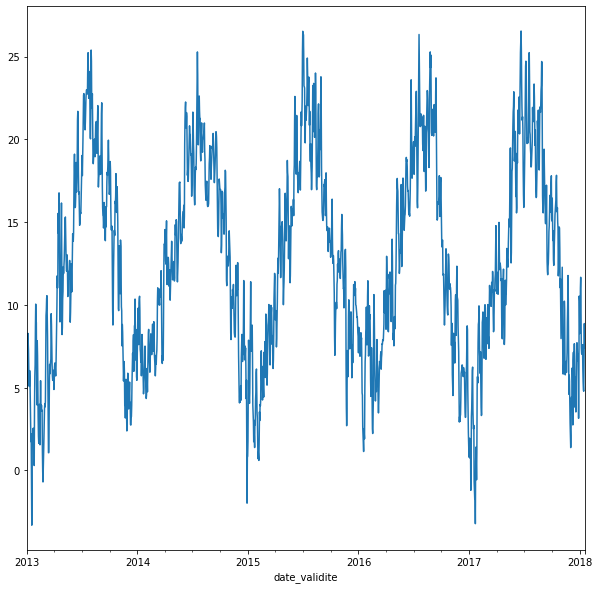

In [15]:
df_temp_fr =  pd.read_pickle(PATH+'df_temperatures.pkl')
df_temp_fr.sort_index().mean(axis=1).resample('1d').mean().plot();

### Capacity

In [16]:
query = """SELECT name FROM sqlite_master
           WHERE type='table'
           ORDER BY name;"""
pd.read_sql_query(query, conn['cap'])

,name
0,national_generation_capacity_stacked


In [17]:
query = """SELECT * FROM national_generation_capacity_stacked
           WHERE country == 'FR'
        """
df_capacity_fr = pd.read_sql_query(query, conn['cap'])

df_capacity_fr = df_capacity_fr[['year', 'technology', 'capacity']]
to_drop = ['Differently categorized fossil fuels',
           'Differently categorized hydro',
           'Differently categorized natural gas',
           'Differently categorized renewable energy sources',
           'Differently categorized solar',
           'Differently categorized wind',
           'Wind', 'Mixed fossil fuels', 'Fossil fuels', 'Renewable energy sources']
mask = df_capacity_fr.technology.apply(lambda x: x in to_drop)
df_capacity_fr = df_capacity_fr.mask(mask).dropna(how='all')

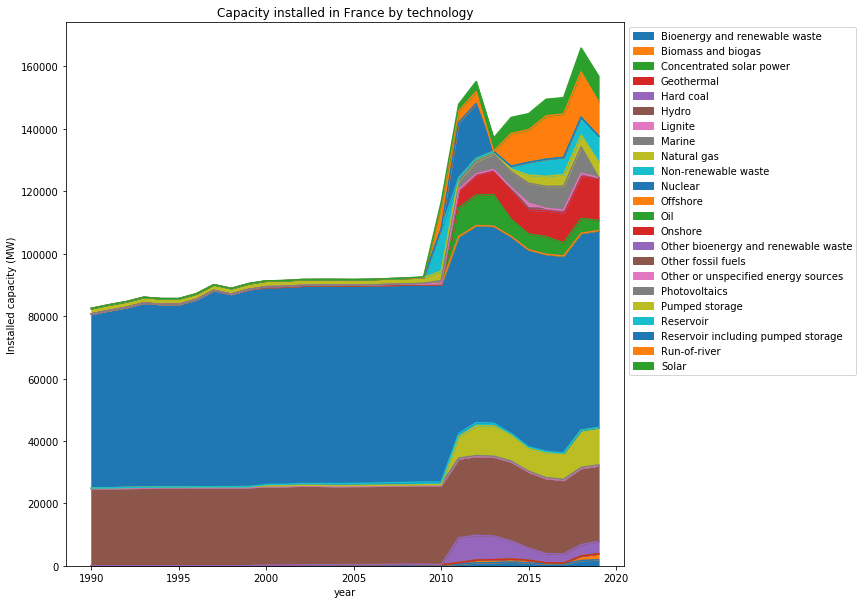

In [18]:
(df_capacity_fr.pivot_table(index='year', columns="technology")
           ['capacity']
           .drop(columns='Total')
           .plot.area(stacked=True))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Capacity installed in France by technology')
plt.ylabel('Installed capacity (MW)');

## Times series de ratio de performance éolienne / solaire

L'objectif est de calculer le ratio d'usage des éoliennes et des pannaux selon le temps de la journée. Puis faire une distribution.

## Import Data RTE

In [23]:
df_capacity_fr = pd.read_pickle(PATH+'capacity_fr.pkl')
df_prod_fr =  pd.read_pickle(PATH+'production_fr.pkl').astype(float)

df_capacity_fr = df_capacity_fr.drop([2015,2016])

## Calculate ratio matrix

In [24]:
map_df_prod_fr = df_prod_fr.set_index(df_prod_fr.index.year, append=True)

In [30]:
map_df_prod_fr.Solaire

2016-01-01 00:00:00  2016    0.0
2016-01-01 01:00:00  2016    0.0
2016-01-01 02:00:00  2016    0.0
2016-01-01 03:00:00  2016    0.0
2016-01-01 04:00:00  2016    0.0
                            ... 
2019-12-31 19:00:00  2019    0.0
2019-12-31 20:00:00  2019    0.0
2019-12-31 21:00:00  2019    0.0
2019-12-31 22:00:00  2019    0.0
2019-12-31 23:00:00  2019    0.0
Name: Solaire, Length: 35041, dtype: float64

In [25]:
mat_ratio = map_df_prod_fr.divide(df_capacity_fr, level=1).dropna(how='all')
mat_ratio

,,Biomasse,Charbon,Déchets,Fioul,Gaz,Hydraulique STEP,Hydraulique fil de l'eau / éclusée,Hydraulique lacs,Nucléaire,Solaire,Éolien terrestre
2017-01-01 00:00:00,2017,1.676471,0.496928,NaN,0.041509,1.104391,0.093454,0.309093,0.383201,0.844638,0.0,0.044513
2017-01-01 01:00:00,2017,1.682353,0.354608,NaN,0.043774,1.089904,0.057200,0.295149,0.284060,0.844131,0.0,0.046650
2017-01-01 02:00:00,2017,1.682353,0.359044,NaN,0.043774,1.035693,-0.118429,0.277525,0.280779,0.841628,0.0,0.046208
2017-01-01 03:00:00,2017,1.682353,0.343003,NaN,0.043774,0.924582,-0.234642,0.277138,0.272153,0.839252,0.0,0.044882
2017-01-01 04:00:00,2017,1.682353,0.347440,NaN,0.043774,0.890233,-0.271299,0.264356,0.209704,0.840900,0.0,0.046945
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,0.180735,0.011094,NaN,0.054112,0.636295,0.373482,0.645185,0.505496,0.786187,0.0,0.163115
2019-12-31 20:00:00,2019,0.181253,0.011094,NaN,0.054418,0.624080,0.211228,0.616796,0.371905,0.775226,0.0,0.198016
2019-12-31 21:00:00,2019,0.180218,0.011094,NaN,0.054418,0.612617,0.115270,0.572798,0.301123,0.778267,0.0,0.208009
2019-12-31 22:00:00,2019,0.180735,0.011094,NaN,0.054418,0.607430,0.056142,0.568964,0.265370,0.775463,0.0,0.222704


Petit soucis sur quelques données qui dépassent les capacités "installées". La matrice de ratio devrait être <= 1. Or, certain ratio sont suppérieurs à 1.

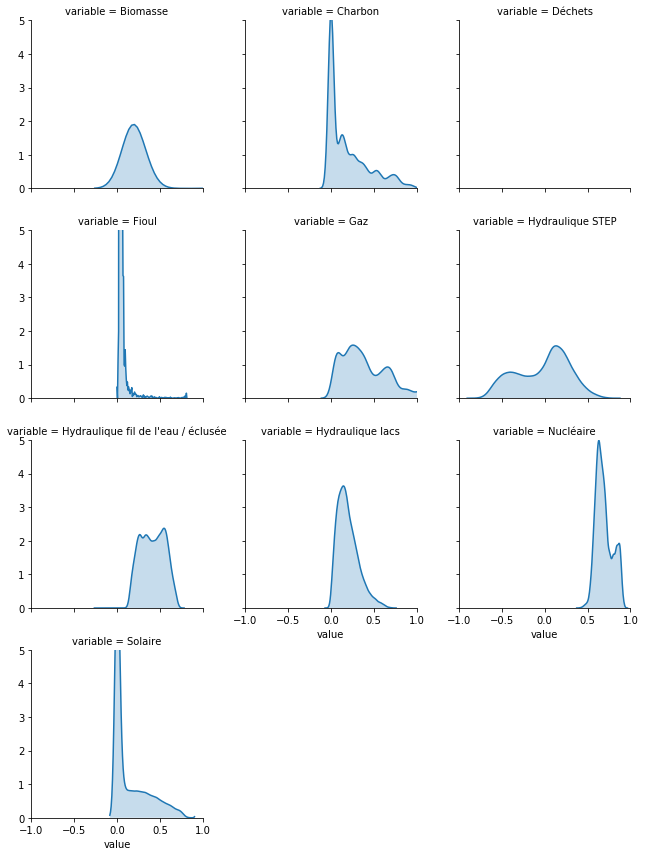

In [26]:
df = pd.melt(mat_ratio, mat_ratio.columns[-1], mat_ratio.columns[:-1])

g = sns.FacetGrid(df, col="variable", col_wrap=3, ylim=(0,5), xlim=(-1,1))
g.map(sns.kdeplot, "value", shade=True)

plt.show()

# Plan of work
- generate an average year +/- variability.
- calculate the capacity of wind/solar/hydro power. Cost function : reduce the overall capacity installed.
- optional: find limit for the hydraulic.
- optional: extract the electricity value consumed for heat with assumptions to play with thermal technology

**Final objectives**: create an abaqus of power to install for a 100% renewable

In [31]:
df_prod_fr

,Biomasse,Gaz,Charbon,Fioul,Hydraulique STEP,Hydraulique fil de l'eau / éclusée,Hydraulique lacs,Nucléaire,Solaire,Déchets,Éolien terrestre
2016-01-01 00:00:00,253.0,2265.0,-3.0,261.0,642.0,2778.0,511.0,54099.0,0.0,90.0,2189.0
2016-01-01 01:00:00,253.0,2232.0,-3.0,260.0,439.0,2562.0,555.0,54079.0,0.0,92.0,1753.0
2016-01-01 02:00:00,253.0,2259.0,-3.0,260.0,-864.0,2514.0,378.0,54058.0,0.0,93.0,1430.0
2016-01-01 03:00:00,253.0,2242.0,-3.0,260.0,-2841.0,2602.0,200.0,52326.0,0.0,93.0,1214.0
2016-01-01 04:00:00,252.0,2251.0,-3.0,258.0,-2876.0,2676.0,390.0,51806.0,0.0,90.0,1031.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,349.0,7605.0,44.0,177.0,1876.0,7068.0,4185.0,49632.0,0.0,211.0,2220.0
2019-12-31 20:00:00,350.0,7459.0,44.0,178.0,1061.0,6757.0,3079.0,48940.0,0.0,211.0,2695.0
2019-12-31 21:00:00,348.0,7322.0,44.0,178.0,579.0,6275.0,2493.0,49132.0,0.0,210.0,2831.0
2019-12-31 22:00:00,349.0,7260.0,44.0,178.0,282.0,6233.0,2197.0,48955.0,0.0,211.0,3031.0


In [35]:
df_prod_fr.columns.values

array(['Biomasse', 'Gaz', 'Charbon', 'Fioul', 'Hydraulique STEP',
       "Hydraulique fil de l'eau / éclusée", 'Hydraulique lacs',
       'Nucléaire', 'Solaire', 'Déchets', 'Éolien terrestre'],
      dtype=object)

In [34]:
renouvelables=['Biomasse','Hydraulique STEP',"Hydraulique fil de l'eau / éclusée",'Hydraulique lacs','Solaire','Éolien terrestre']
autres = ['Gaz','Charbon','Fioul',]
df_prod_fr_rnw_others = pd.DataFrame(columns=['Renouvelable','Autres'])
df_prod_fr_rnw_others['Renouvelables'] = 

,Renouvelable,Autres
